In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import time

from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import max_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor  
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## Data loading

In [4]:
df = pd.read_csv('data\Life-Expectancy-Data-Updated.csv')

# Simple renaming to improve readability
df=df.rename(columns={'Thinness_ten_nineteen_years':'Thinness (10-19 years)',\
                      'Thinness_five_nine_years':'Thinness (5-9 years)', \
                      'Economy_status_Developed' : 'Developed', \
                      'Economy_status_Developing' : 'Developing'                  
                     })
df_reduced = df.drop(['Infant_deaths', 'Under_five_deaths', 'Diphtheria', 'Thinness (5-9 years)', 'Developing'], axis=1)
df_reduced = df_reduced[df_reduced['Developed']==0]
df_reduced.head()

,Country,Region,Year,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Incidents_HIV,GDP_per_capita,Population_mln,Thinness (10-19 years),Schooling,Developed,Life_expectancy
0,Turkiye,Middle East,2015,105.8240,1.32,97,65,27.8,97,0.08,11006,78.53,4.9,7.8,0,76.5
2,India,Asia,2007,201.0765,1.57,60,35,21.2,67,0.13,1076,1183.21,27.1,5.0,0,65.4
3,Guyana,South America,2006,222.1965,5.68,93,74,25.3,92,0.79,4146,0.75,5.7,7.9,0,67.0
5,Costa Rica,Central America and Caribbean,2006,95.2200,4.19,88,86,26.4,89,0.16,9110,4.35,2.0,7.9,0,78.2
6,Russian Federation,Rest of Europe,2015,223.0000,8.06,97,97,26.2,97,0.08,9313,144.10,2.3,12.0,0,71.2


## Model selection

In [6]:
# Returns (X, y)
def split(df):
    X = df.drop(columns=['Country', 'Region', 'Year', 'Developed', 'Life_expectancy'])
    y = df['Life_expectancy']
    return X, y

### PCA Analysis

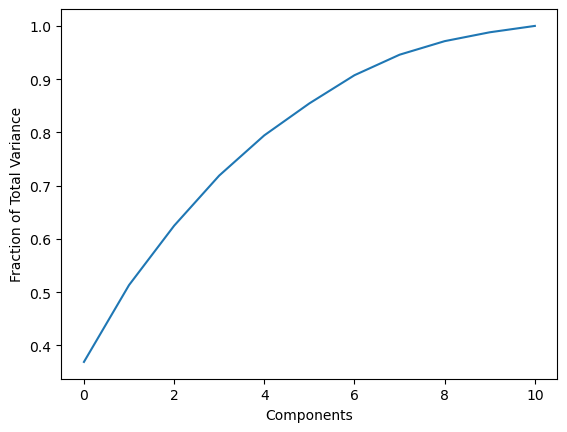

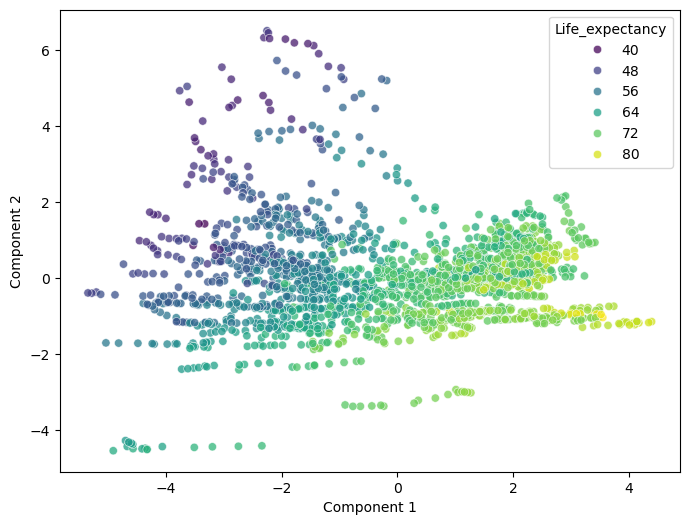

In [8]:
def pca_analysis(df):
    X, _ = split(df)
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA()
    _ = pca.fit_transform(X_scaled)
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Components')
    plt.ylabel('Fraction of Total Variance')

    pca_components = PCA().fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['Life_expectancy'], palette='viridis', alpha=0.75);
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.show()

pca_analysis(df_reduced)

In [9]:
df_train, df_test = train_test_split(df_reduced, test_size=0.2, random_state=42)

### Model comparison

In [11]:
def get_model_stats(model):
    X_train, y_train = split(df_train)
    X_test, y_test = split(df_test)

    model_internal = clone(model)
    # Scale inputs - irrelevant for decision tree based models but important for KNN
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) 
    
    t0 = time.time()
    count = 25
    for _ in range(count):
        model_internal.fit(X_train_scaled, y_train)
    train_time = (time.time() - t0)/count

    t0 = time.time()
    count = 250
    for _ in range(count):
        y_predict = model_internal.predict(X_test_scaled)
    predict_time = (time.time() - t0)/count
    
    model_internal.fit(X_train_scaled, y_train)
    y_predict = model_internal.predict(X_test_scaled)
    result = {
                'Mean squared error': mean_squared_error(y_predict, y_test),
                'Mean absolute error': mean_absolute_error(y_predict, y_test),
                'Mean Absolute Percentage Error': mean_absolute_percentage_error(y_predict, y_test),
                'Maximum Error': max_error(y_predict, y_test),
                'r2 Score': r2_score(y_predict, y_test), 
                'Training Time': train_time,
                'Prediction Time' : predict_time        
            }
    return result

In [12]:
def compare_models(models):
    results = []
    for (name, model) in models:
        res = get_model_stats(model)
        res['Name'] = name
        results.append(res)
    return pd.DataFrame(results).set_index('Name').sort_values('Mean squared error')

compare_models(
        { 
            ('Linear', LinearRegression()), 
            ('Decision Tree', DecisionTreeRegressor(random_state=42)),
            ('Random Forest', RandomForestRegressor(random_state=42)),
            ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
            ('XG Boost', XGBRegressor()),
            ('KNN', KNeighborsRegressor())
        })

,Mean squared error,Mean absolute error,Mean Absolute Percentage Error,Maximum Error,r2 Score,Training Time,Prediction Time
Name,,,,,,,
Random Forest,0.435100,0.457741,0.007464,3.462000,0.994420,0.849975,0.008127
XG Boost,0.455953,0.474207,0.007700,3.536771,0.994213,0.076772,0.003200
Decision Tree,1.154527,0.682418,0.011247,5.000000,0.985465,0.012436,0.000464
Gradient Boosting,1.267064,0.895290,0.013998,3.316263,0.983416,0.321368,0.001045
KNN,1.583601,0.858286,0.014091,6.340000,0.979251,0.003029,0.007200
Linear,4.671710,1.739015,0.027896,7.755905,0.938115,0.001590,0.000545


Random Forest has slightly better MSE than XGBoost however the time for execution for XGBoost is very much faster. This is a significant benefit when performing scenario analysis using the model.

**We select the XGBoost model**

### Optimising XGBoost model

We use cross-validation to find the optimal parameters

### Cross validation

In [16]:
def score_folds(model, df, n_splits, random_state=42):
    scores = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        X_train, y_train = split(df.iloc[train_index]) # [columns]
        X_test, y_test = split(df.iloc[test_index]) # [columns]
        model_internal = clone(model)
        model_internal.fit(X_train, y_train)
        y_predict = model_internal.predict(X_test)
        scores.append(mean_squared_error(y_predict, y_test))
    return scores

In [17]:
def scorer(params):
    model = XGBRegressor(**params)
    scores = score_folds(model, df_reduced, 5)
    mean = np.mean(scores)
    print(params, mean)
    return mean

param_grid={'learning_rate': [0.05, 0.1, 0.2],
            'max_depth':[2, 4, 6, 8, 10, 12]}

grid = ParameterGrid(param_grid)
it2 = map(lambda p: (p, scorer(p)), grid)
best_params, _ = min(it2, key=lambda t: t[1])
print(best_params)

{'learning_rate': 0.05, 'max_depth': 2} 3.0258919897314613
{'learning_rate': 0.05, 'max_depth': 4} 1.2321826661397501
{'learning_rate': 0.05, 'max_depth': 6} 0.5981373056011782
{'learning_rate': 0.05, 'max_depth': 8} 0.4514549066872533
{'learning_rate': 0.05, 'max_depth': 10} 0.4595373853140433
{'learning_rate': 0.05, 'max_depth': 12} 0.4630475811718363
{'learning_rate': 0.1, 'max_depth': 2} 2.241581889404248
{'learning_rate': 0.1, 'max_depth': 4} 0.8713032937638221
{'learning_rate': 0.1, 'max_depth': 6} 0.4478554921654677
{'learning_rate': 0.1, 'max_depth': 8} 0.40580362109092477
{'learning_rate': 0.1, 'max_depth': 10} 0.40558307565729124
{'learning_rate': 0.1, 'max_depth': 12} 0.42445589515925874
{'learning_rate': 0.2, 'max_depth': 2} 1.7196994526016902
{'learning_rate': 0.2, 'max_depth': 4} 0.608136435062215
{'learning_rate': 0.2, 'max_depth': 6} 0.41576907949108166
{'learning_rate': 0.2, 'max_depth': 8} 0.4361017124200147
{'learning_rate': 0.2, 'max_depth': 10} 0.448885981384464
{'

In [18]:
model = XGBRegressor(**best_params).fit(*split(df_train))

In [19]:
print(get_model_stats(model))

{'Mean squared error': 0.3216819760767581, 'Mean absolute error': 0.3735253369677199, 'Mean Absolute Percentage Error': 0.006061846359362674, 'Maximum Error': 3.780355072021486, 'r2 Score': 0.9958671049392089, 'Training Time': 0.31350638389587404, 'Prediction Time': 0.0037659206390380858}


## Model results

### Plots

In [22]:
def plot_results(df):
    (X, y) = split(df)
    y_predict = model.predict(X)
    plt.scatter(y_predict, y)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

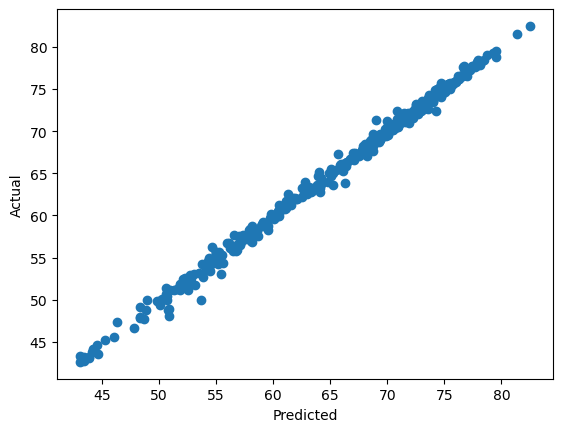

In [23]:
plot_results(df_test)

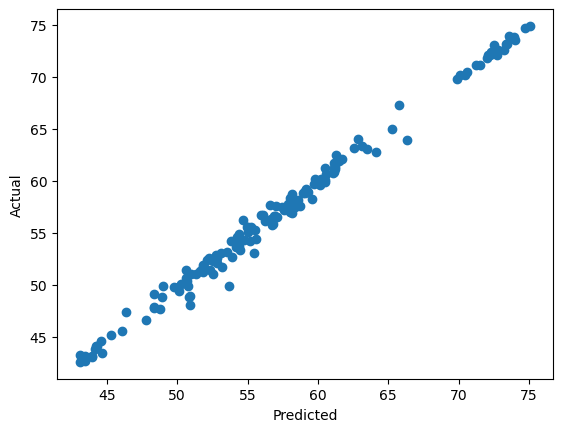

In [24]:
plot_results(df_test[df_test['Region']=='Africa'])

### Residuals

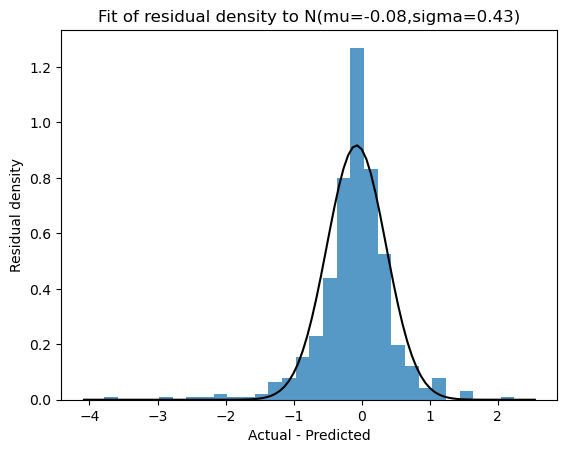

In [26]:
def plot_residuals(df):
    (X, y) = split(df)
    y_predict = model.predict(X)
    z = y-y_predict
    plt.hist(z, bins=30, alpha=0.75, density=True)

    # Exclude  outliers and fit to a normal
    z=z[np.abs(z)<1.5]
    mu, sigma = stats.norm.fit(z)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, p, 'k', linewidth=1.5)
    
    title = f'Fit of residual density to N(mu={mu:.2f},sigma={sigma:.2f})'
    plt.title(title)
    plt.xlabel('Actual - Predicted')
    plt.ylabel('Residual density')
    plt.show()

plot_residuals(df_test)

### Permutation importance

In [28]:
def perm_importance(df):
    (X, y) = split(df)
    result = permutation_importance(model, X, y, n_repeats=100, random_state=42, n_jobs=2)
    idx = result.importances_mean.argsort()
    return pd.DataFrame(result.importances[idx].T, columns=X.columns[idx])

def plot_h(train, test):
    ax = plt.subplot(111)
    ind = np.arange(len(train.index))
    height=0.3
    ax.barh(ind+height/2, train, height, label='Train')
    ax.barh(ind-height/2, test, height, label='Test')
    ax.set(yticks=ind, yticklabels=train.index, ylim=[-2*height, len(ind)-height])
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.legend(loc='lower right')
    plt.show()

#### All developing countries

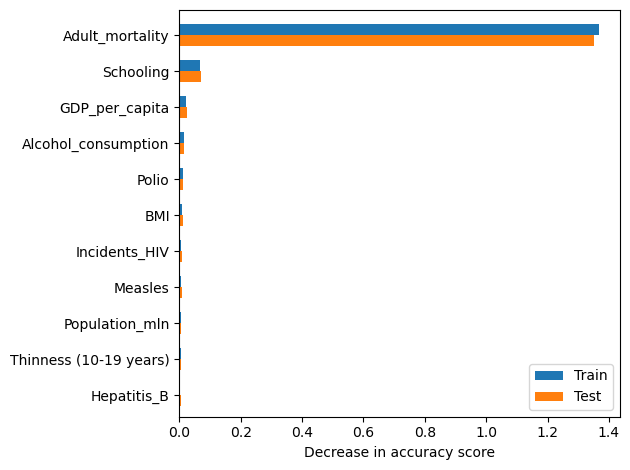

In [30]:
importance_train = perm_importance(df_train)
importance_test = perm_importance(df_test)
plot_h(importance_train.mean(axis=0), importance_test.mean(axis=0))

In [31]:
#### Africa

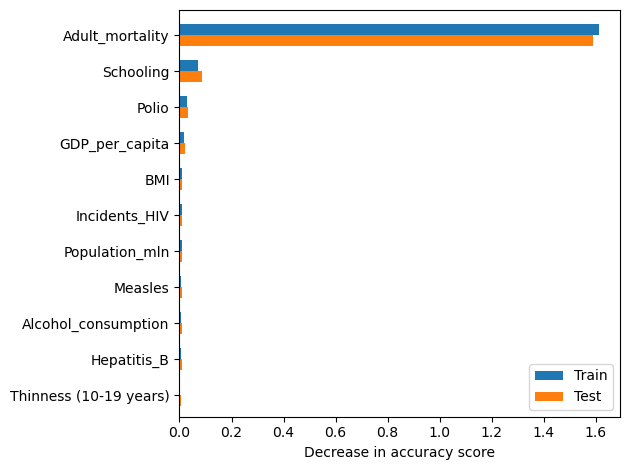

In [32]:
importance_train_africa = perm_importance(df_train[df_train['Region']=='Africa'])
importance_test_africa = perm_importance(df_test[df_test['Region']=='Africa'])
plot_h(importance_train_africa.mean(axis=0), importance_test_africa.mean(axis=0))

### Partial dependence

In [34]:
def partial_dep(df, feature):
    X, _ = split(df)
    PartialDependenceDisplay.from_estimator(model, X, [feature], kind='both')
    plt.show()

#### All developing countries

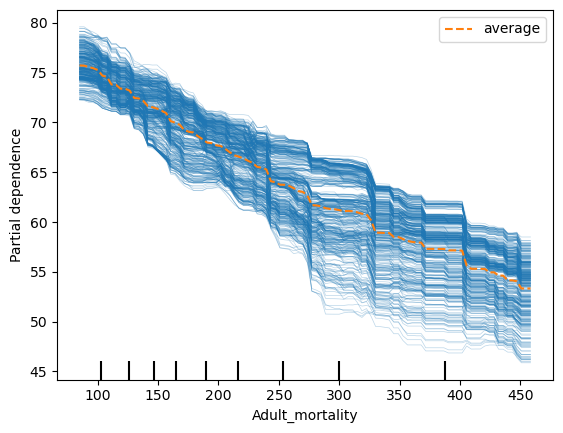

In [36]:
partial_dep(df_test, 'Adult_mortality')

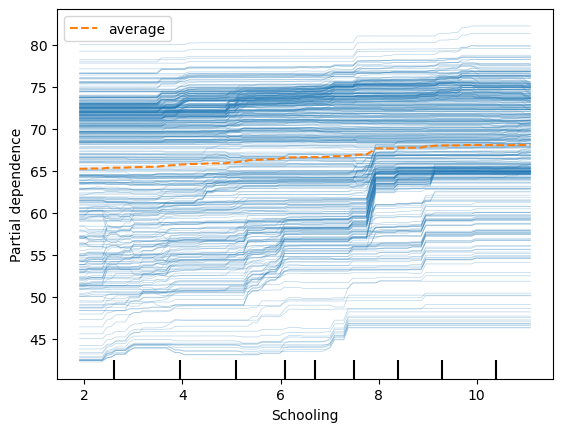

In [37]:
partial_dep(df_test, 'Schooling')

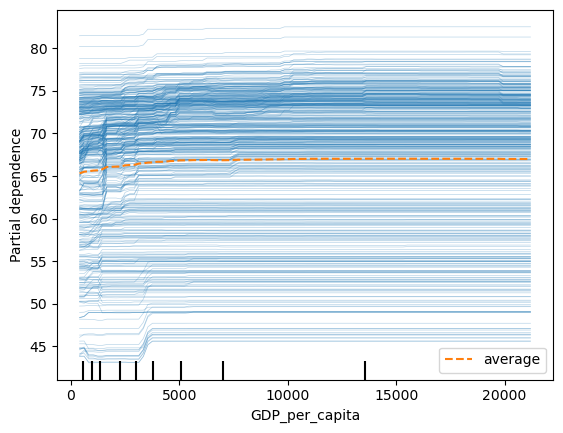

In [38]:
partial_dep(df_test, 'GDP_per_capita')

#### Africa

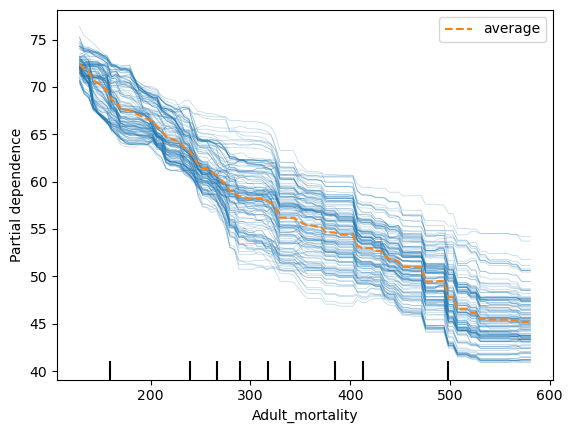

In [40]:
partial_dep(df_test[df_test['Region']=='Africa'], 'Adult_mortality')

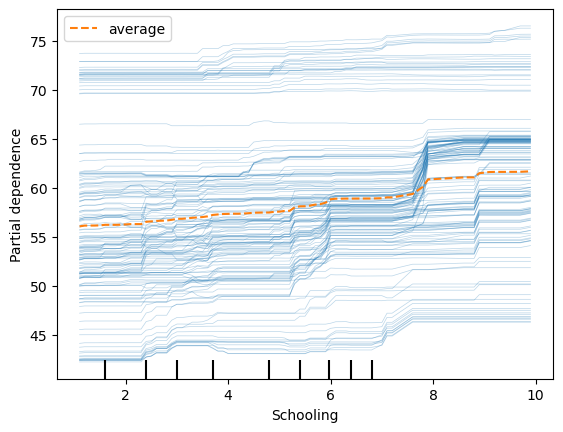

In [41]:
partial_dep(df_test[df_test['Region']=='Africa'], 'Schooling')

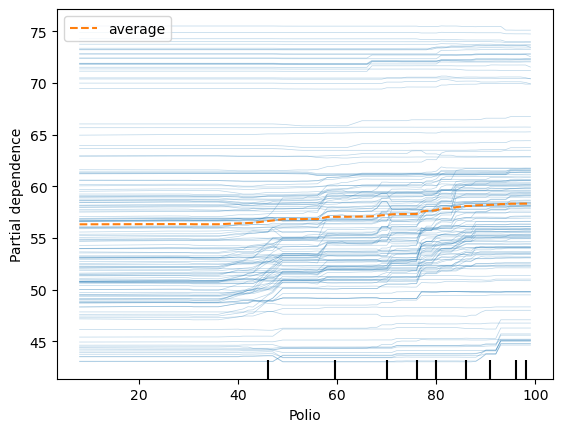

In [42]:
partial_dep(df_test[df_test['Region']=='Africa'], 'Polio')